In [29]:
import pickle
import pandas as pd 
import bokeh.palettes as palettes
import sys
sys.path.insert(0, '../scripts/')
import coref_resolution_util as c
import rules_method_num_3 as c
from more_itertools import unique_everseen
from copy import deepcopy
from IPython.display import display, HTML
import numpy as np
from importlib import reload
reload(c)
import glob
import json

def generate_packet_to_annotate(q, s):
    l = list(map(len, s))
    if len(q) < 10:
        cmap = palettes.Set3_11
    elif len(q) < 20:
        cmap = list(unique_everseen(palettes.Set3_11 + palettes.Spectral11))
    else:
        cmap = list(unique_everseen( palettes.Set3_11 + palettes.Spectral11 + palettes.Category20_20))

    comp_mapper = {i:idx for idx, i in enumerate(q.index.tolist())}
    source_idx_head_mapper = (
     q
     .assign(head=lambda df: df.apply(lambda x: ' '.join(s[x['head_s_idx']][
            x['head_span'][0] - sum(l[:x['head_s_idx']]):
            x['head_span'][1] - sum(l[:x['head_s_idx']])
        ]
        ), axis=1 ))
        ['head'].to_dict()
    )

    span_df = (
     q
     .assign(q=lambda df: df.apply(lambda x: 
       list(map(lambda y: {'source': x.name, 'sent': y[0], 'span': y[1], 'type': 'quote'}, x['quote_chunks'] )), axis=1))
     .assign(b=lambda df: df.apply(lambda x: 
       list(map(lambda y: {'source': x.name, 'sent': y[0], 'span': y[1], 'type': 'background'}, x['background_chunks'] )), axis=1))
     .apply(lambda x: x['q'] + x['b'], axis=1)
     .pipe(lambda s: pd.DataFrame(c.flatten_list_of_lists(s.tolist())))
     .sort_values('sent', ascending=False)
     .assign(head=lambda df: df['source'].map(source_idx_head_mapper))
     .assign(source=lambda df: df['source'].map(comp_mapper))
    )

    s_html = deepcopy(s)
    old_s_idx = None
    # quotes and backgrounds
    for idx, (source_idx, sent_idx, quote_span, quote_type, head) in span_df.iterrows():
        if old_s_idx != sent_idx:
            adj = sum(l[:sent_idx])
        sent, adj = c.format_span_with_word_list(adj=adj, sent=s[sent_idx], span=quote_span, bold=True)
        s_html[sent_idx] = {
            'sent':' '.join(sent),
            'type': quote_type.upper(),
            'head': head,
            'color': cmap[source_idx],
            'source_idx': source_idx,            
        }

    # regular
    for s_idx, sent in enumerate(s_html):
        if isinstance(sent, list):
            s_html[s_idx] = {
                'sent': ' '.join(sent), 
                'type': '',
                'source_idx': 'null',
            }
    
    for s_idx in range(len(s_html)):
        s_html[s_idx]['sent_idx'] = s_idx
    
    return s_html

In [6]:
fs = glob.glob('../resources/data/output/news-categories-newssniffer/articles-sans-headlines/*')
all_processed = []
for fname in fs:
    with open(fname, 'rb') as f:
        processed = pickle.load(f)
        all_processed.extend(processed)

In [7]:
processed_df = (
    pd.DataFrame(all_processed)
    .drop_duplicates('entry_id')
)

In [10]:
import os 
from tqdm.auto import tqdm
import sqlite3
import pandas as pd 

In [14]:
! gunzip ../../edit-pathways/data/diffengine-diffs/db/newssniffer-nytimes.db.gz

In [15]:
db_path = '../../edit-pathways/data/diffengine-diffs/db/newssniffer-nytimes.db'
conn = sqlite3.connect(db_path)
orig_data_entries = pd.read_sql(
    '''SELECT * FROM entryversion 
        WHERE entry_id IN (%s) and version = 0
    ''' % ', '.join(processed_df['entry_id'].astype(str)), con=conn)

In [16]:
data_df = processed_df.merge(
    orig_data_entries[['entry_id', 'version', 'title', 'created', 'url']], 
    right_on=['entry_id', 'version'], 
    left_on=['entry_id', 'version']
)

In [55]:
import jsonlines
annotated_data = list(jsonlines.open('../tasks/data_split_annotated_sources.jsonl'))
doc_id_annotated_data = []
for a in annotated_data:
    a['doc_id'] = int(a['data'][0]['doc_id'])
    doc_id_annotated_data.append(a)
annotated_data_df = pd.DataFrame(doc_id_annotated_data)

In [57]:
data_df_with_annotated = data_df.merge(annotated_data_df, left_index=True, right_on='doc_id')

/var/folders/89/6dsq1ymj63x009t6wpt25f9h0000gp/T/ipykernel_10736/1188513959.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=25);


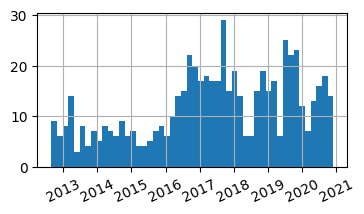

In [70]:
ax = pd.to_datetime(data_df_with_annotated['created']).hist(bins=50, figsize=(4,2))
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=25);

In [82]:
data_df_with_annotated[['data', 'doc_id', 'url']].to_json(
    '../tasks/annotated_sources_with_urls.jsonl', 
    orient='records', 
    lines=True
)

In [327]:
data_df['quote_idxes'].iloc[0].loc[lambda df: df['quote_chunks'].str.len()>0]

,head_span,head_s_idx,quote_chunks,background_chunks
head_ref,,,,
2,"(683, 685)",27,"[(32, (804, 805)), (30, (756, 757))]","[(33, (809, 810)), (34, (808, 810)), (27, (683..."


In [355]:
data_df.head(1)

,entry_id,version,quote_idxes,sent_parse,label,title,created,url
0,1940909,0,head_span head_s_idx ...,"[[A, two, -, day, rally, in, global, stocks, l...",Labor,Asian Markets Signal End to Global Rally: Live...,2020-05-06 04:38:00+00:00,https://www.nytimes.com/2020/05/06/business/st...


In [30]:
for idx in tqdm(range(len(data_df))):
    q = (
        data_df
         .iloc[idx]['quote_idxes']
         .loc[lambda df: df['quote_chunks'].str.len() > 0]
        )
    if len(q) > 0:
        s = data_df.iloc[idx]['sent_parse']
        s_html = generate_packet_to_annotate(q, s)

        dirname = '../app/data/input_data/%s' % int(idx / 50)
        if not os.path.exists(dirname):
            os.makedirs(dirname)


        output_data = {}
        output_data['html_data'] = s_html
        output_data['label'] = data_df.iloc[idx]['label']
        output_data['entry_id'] = int(data_df.iloc[idx]['entry_id'])
        output_data['version'] = int(data_df.iloc[idx]['version'])
        output_data['url'] = data_df.iloc[idx]['url']
        output_data['published_date'] = data_df.iloc[idx]['created']
        output_data['headline'] = data_df.iloc[idx]['title']
        break
        with open(dirname + '/to-annotate-%s.json' % idx, 'w') as f:
            json.dump(output_data, f)

  0%|          | 0/957 [00:00<?, ?it/s]

In [341]:
(data_df
 .assign(num_quotes=lambda df: df['quote_idxes'].apply(lambda df: df['quote_chunks'].loc[lambda df: df.str.len() > 0].shape[0]))
 .loc[lambda df: df['num_quotes'] > 0]
 ['label'].value_counts()
)

Elections      215
Disaster       179
Labor          174
Safety         152
Environment     78
Name: label, dtype: int64

In [261]:
to_annotate = glob.glob('../app/data/input_data/*/*')

In [264]:
t = sorted(list(map(lambda x: x.split('-')[-1], to_annotate)), key=lambda x: int(x.replace('.json', '')))

In [183]:
display(HTML('<br><br>'.join(s_html).replace('$', '\$')))

TypeError: sequence item 0: expected str instance, dict found

# Examine output data

In [273]:
ls ../app/data/output_data/0/

annotated-0.json  annotated-2.json  annotated-4.json
annotated-1.json  annotated-3.json


In [274]:
with open('../app/data/output_data/0/annotated-0.json') as f:
    t = json.load(f)

In [276]:
t

{'0': {'s_idx': 0,
  'sentence': 'Great Barrier Reef Is Not ‘ in Danger ’ but',
  'head': '',
  'quote_type': '',
  'error': 'No Errors',
  'affiliation': '',
  'role': '',
  'role_status': '',
  'gender': '',
  'race': '',
  'age': '',
  'education': ''},
 '1': {'s_idx': 1,
  'sentence': 'Needs Care',
  'head': 'Needs Care',
  'quote_type': 'BACKGROUND',
  'error': 'No Errors',
  'affiliation': '',
  'role': '',
  'role_status': '',
  'gender': '',
  'race': '',
  'age': '',
  'education': ''},
 '2': {'s_idx': 2,
  'sentence': ', U.N. Experts Say .',
  'head': '',
  'quote_type': '',
  'error': 'No Errors',
  'affiliation': '',
  'role': '',
  'role_status': '',
  'gender': '',
  'race': '',
  'age': '',
  'education': ''},
 '3': {'s_idx': 3,
  'sentence': 'SYDNEY , Australia —',
  'head': '',
  'quote_type': '',
  'error': 'No Errors',
  'affiliation': '',
  'role': '',
  'role_status': '',
  'gender': '',
  'race': '',
  'age': '',
  'education': ''},
 '4': {'s_idx': 4,
  'sentence'

In [275]:
t.pop('start_time', '')

'1645601382.208365'

In [211]:
sorted_keys = sorted(t.keys(), key=lambda x: int(x))

In [214]:
t_list = list(map(lambda k: t[k], sorted_keys))

In [219]:
t_df = pd.DataFrame(t_list)
t_df.head()

,s_idx,sentence,head,quote_type,error,affiliation,role,gender,race,age,education
0,0,"SANTIAGO , Chile —",,,No Errors,,,,,,
1,1,They appear at the student demonstrations that...,,,No Errors,,,,,,
2,2,They are not there to join the protests or int...,,,No Errors,,,,,,
3,3,"This month , they are busier than ever .",,,No Errors,,,,,,
4,4,"The volunteer observers , known as “ helmets ,...",,,No Errors,,,,,,


In [223]:
(t_df
 .groupby('head')
 [['affiliation', 'role', 'gender', 'race', 'age', 'education']]
 .aggregate(list)
 .applymap(lambda x: list(set(x)))
)

,affiliation,role,gender,race,age,education
head,,,,,,
,[],[],[],[],[],[]
Germán Chau,[NGO],[Decision Maker],[],[],[66],[]
Luis Parra,"[, NGO]","[, Decision Maker]","[, Male]","[, Latinx]","[, 56]","[Law, ]"
Marta Cisterna,"[, NGO]","[, Informational]","[, Female]","[, Latinx]","[, 45]",[]
Matías Sotelo,"[, NGO]","[, Decision Maker]","[, Male]","[, Latinx]","[, 23]","[, MD]"


In [87]:
len(orig_speaking_lexicon + polinear_speaking_lexicon + multiword_phrases_past_tense + multiword_phrases_present_tense)

538

In [89]:
len(desired_checklist_of_anonymous_sources + desired_checklist_of_documents)

300